# Unveiling Bias in Gender Violence Perception on Italian Social Media

## Importing Libraries

In [1]:
%pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [41]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import spacy
import nltk
from cleantext import clean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cicci\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
!python -m spacy download it_core_news_sm

     --------------------------------------- 13.0/13.0 MB 15.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


## Reading and Cleaning Data

### Read Df

This data frame comes from extensive and hard scraping on Nitter, one of the last available resources to scrape Twitter without rate limits and high expenses. However, because of the instability of the various instances, we are not sure the results will be easily replicated if trying to run again the twitter.ipynb script. 

In [4]:
# read the data
df = pd.read_csv('twitter_data_ext.csv')

In [5]:
# drop the first column
# df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,Apr 19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,Apr 19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,Apr 19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,Apr 19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,Apr 19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


In [6]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62624 entries, 0 to 62623
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      62624 non-null  object
 1   username  62624 non-null  object
 2   date      62624 non-null  object
 3   text      62622 non-null  object
 4   comments  62624 non-null  int64 
 5   retweets  62624 non-null  object
 6   quotes    62624 non-null  int64 
 7   likes     62624 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


The dates of 2024 have been saved with just day and month, therefore we need to add the year

In [7]:
# add the year to all the dates of 2024
df['date'] = df['date'].apply(lambda x: x + ' 2024' if len(x) < 10 else x)

In [8]:
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'])

In [9]:
# clean the text column
df['text'] = df['text'].apply(lambda x: str(x).replace('\n', ' '))

In [10]:
# first five rows
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


This is the cleaned final data frame!

## Exploratory Data Analysis

### Polarization event

We chose as a polarization event the "Cecchettin case", that greatly moved public opinion regarding the hot topic of violence on women in italy.

In [11]:
# create a variable for the polarizing event
pol_event = dt.datetime(2023, 11, 11)

### Simple Tweet Count

In [12]:
# group the data by date
count_by_date = df.groupby('date').count()
count_by_date['cum_sum'] = count_by_date['user'].cumsum()
count_by_date.head()

,user,username,text,comments,retweets,quotes,likes,cum_sum
date,,,,,,,,
2022-02-16,15,15,15,15,15,15,15,15
2022-02-17,24,24,24,24,24,24,24,39
2022-02-18,19,19,19,19,19,19,19,58
2022-02-19,11,11,11,11,11,11,11,69
2022-02-20,4,4,4,4,4,4,4,73


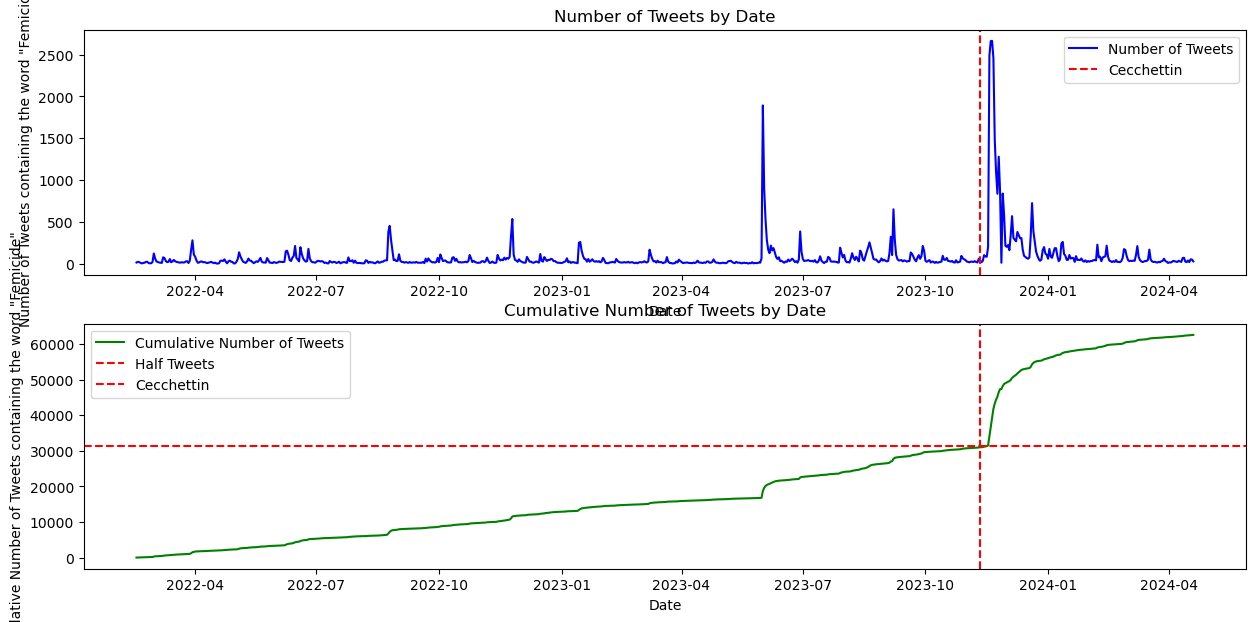

In [13]:
# plot the number of tweets by date
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
ax = axs[0]
ax.plot(count_by_date.index, count_by_date['text'], label='Number of Tweets', color='blue')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets containing the word "Femicide"')
ax.legend()

ax = axs[1]
ax.plot(count_by_date.index, count_by_date['cum_sum'], label='Cumulative Number of Tweets', color='green')
ax.axhline(count_by_date['cum_sum'].max()/2, color='red', linestyle='--', label='Half Tweets')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Cumulative Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Number of Tweets containing the word "Femicide"')
ax.legend()

plt.show()

### Number of Different Users

In [14]:
# count the number of different users
n_different_users = df['user'].nunique()
print(f'There are {n_different_users} different users in the dataset (that contains {len(df)} tweets)')

There are 23743 different users in the dataset (that contains 62624 tweets)


In [15]:
# list of all different users
different_users = df['user'].unique()
different_users

array(['Sciking', '💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫',
       'pubblicanow.it', ...,
       '.•.°• 🦦|| young royals & liceali gay era °.•', 'Lucia Guarano',
       'Laura Garavini'], dtype=object)

In [16]:
users_df = df.groupby('user').agg(list).reset_index()
users_df['username'] = users_df['username'].apply(lambda x: x[0])
users_df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,raffaele52,@raffaele521,[2023-11-21 00:00:00],[La sua conoscenza del femminicidio è straordi...,[0],[0],[0],[0]
1,Shana Loricco,@shanaloricco201,[2023-12-05 00:00:00],"[Parole forti, chiare. Giuste.\r #LorenzoGaspa...",[0],[0],[0],[0]
2,"""Lehodettocresci"" E io sono cresciuta🌈🌻",@nagioia08,"[2023-10-04 00:00:00, 2023-06-01 00:00:00, 202...",[D'altronde\r Pi3rsilvio ha cacciato la d'urso...,"[0, 0, 2, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[ 8, 0, 0, 3]"
3,"""seneca&pericle""",@senecaepericle,[2023-01-24 00:00:00],[Non parliamo poi del femminicidio...],[0],[0],[0],[0]
4,# claudia ✧ 🔭,@308bangtan,[2023-08-01 00:00:00],"[in realtà penalmente parlando non è uguale, u...",[0],[0],[0],[0]


In [17]:
users_df['n_tweets'] = users_df['text'].apply(lambda x: len(x))

### Number of Tweets per User

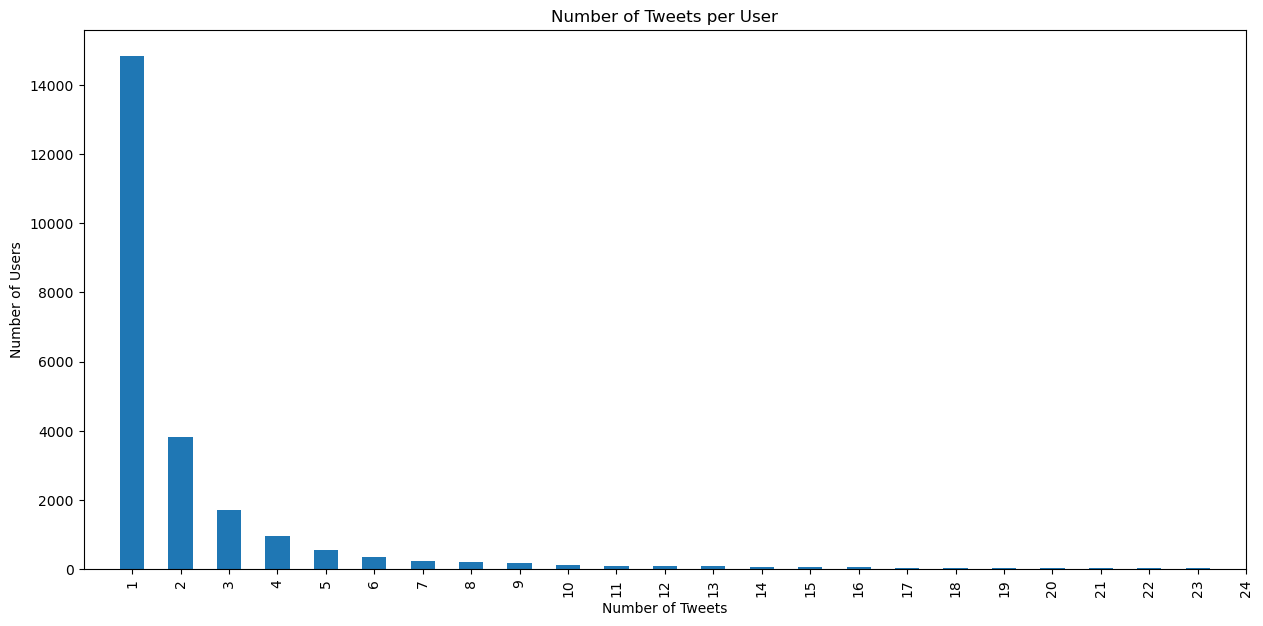

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
users_df['n_tweets'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Tweets per User')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Users')
ax.set_xlim(-1, 23)

plt.show()

In [19]:
with open('users.csv', 'w') as f:
    users = users_df.sort_values('n_tweets', ascending=False)['username'].values
    for user in users:
        f.write(user + ',' + '\n')

### Label Institutions

In [21]:
usernames = [
    "@repubblica", "@LaStampa", "@Corriere", "@ilmessaggeroit", "@ilgiornale", "@fattoquotidiano",
    "@TV2000it", "@SkyTG24", "@Tg3web", "@MediasetTgcom24", "@tg2rai", "@TgLa7",
    "@Radio1Rai", "@rtl1025", "@RaiNews", "@RadioVoceVicina", "@RADIOBRUNO1", "@RadioCapital_fm",
    "@fanpage", "@globalistIT", "@Agenzia_Ansa", "@LaPresse_news", "@direpuntoit", "@Adnkronos",
    "@VanityFairIt", "@361_magazine", "@InsertoMagazine",
    "@giallolorca", "@genderedform", "@GQ_Italia", "@Internazionale",
    "@fisco24_info", "@bizcommunityit", "@magzinemag",
    "@Noviolenzadonne", "@NonunadimenoF", "@amnestyitalia",
    "@bizcommunityit", "@AgenPolitica", "@Femminicidio",
    "@Movimento5Stelle", "@leganord", "@ForzaItalia", "@DemocraziaAtea"
]

# usernames_2 = 

In [22]:
def is_in_list(x, lis):
    if x in lis:
        return 1
    else:
        return 0

In [23]:
df['is_institution'] = df['username'].apply(lambda x: is_in_list(x, usernames))

<Axes: >

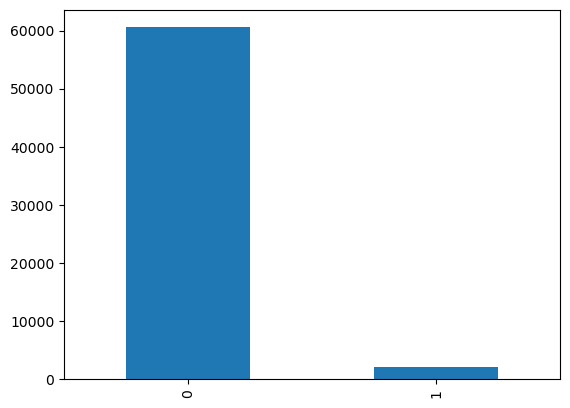

In [24]:
df['is_institution'].value_counts().plot(kind = 'bar')

## Data Processing

### Split Dates

In [25]:
pol_event_date = dt.datetime(2023, 11, 11)
df['after'] = 0
df.loc[df['date'] > pol_event_date, 'after'] = 1

### Create Hashtag Column

In [26]:
# function to get hashtags
def get_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    if hashtags != []:
        return re.findall(r'#\w+', text)
    else:
        return np.nan

In [27]:
df['hashtags'] = df['text'].apply(get_hashtags)

In [28]:
df.loc[df['hashtags'].notna(), 'hashtags'].reset_index(drop=True)

0                            [#femminicidio, #femminicidi]
1                                               [#Raiplay]
2                                          [#Femminicidio]
3                    [#Attualità, #Italia, #UltimeNotizie]
4                                   [#Sardegna, #violenza]
                               ...                        
22072    [#humanrights, #Imrali, #Turkey, #FreeOcalanNo...
22073            [#humanrights, #Turkey, #Kurds, #podcast]
22074                                     [#FreeOcalanNow]
22075                        [#eutanasialegale, #medioevo]
22076         [#uominimaltrattanti, #femminicidio, #donne]
Name: hashtags, Length: 22077, dtype: object

### Clean Tweets

In [30]:
def remover(text, chars = ['@', '#', 'http']):

    starting_chars = '|'.join(chars)
    for word in text.split():
        if re.match(f'{starting_chars}[A-za-z]+', word):
            text = text.replace(word, '')
        
    return text

In [31]:
def remove_apostrophe(text):
    return text.replace("'", " ")

In [32]:
def remove_words_under(text, n=3):
    return ' '.join([word for word in text.split() if len(word) > n])

In [33]:
def duster(text):
    return remove_words_under(remove_apostrophe(remover(text)))

In [34]:
df['clean_text'] = df['text'].apply(lambda x: duster(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: clean(x, no_urls=True, no_emails=True, no_phone_numbers=True, no_numbers=True, no_digits=True, no_currency_symbols=True, no_punct=True, no_emoji=True, replace_with_url='', replace_with_email='', replace_with_phone_number='', replace_with_number='', replace_with_digit='', replace_with_currency_symbol='', replace_with_punct=''))

In [35]:
df['clean_text'].head()

0    solo donne possono parlare aborto solo uomini ...
1                                                     
2    paesi baschi aiuto annuale orfani femminicidio...
3    ambasciata italia vienna aderisce alla campagn...
4    speriamo qualche femminicidio omicidio buon la...
Name: clean_text, dtype: object

In [44]:
#nlp = spacy.load('it_core_news_sm')
from nltk.corpus import stopwords
italian_stopwords = stopwords.words('italian')

In [45]:
texts_before = df.loc[(df['after'] == 0) & (df['is_institution'] == 0), 'clean_text'].values
texts_after = df.loc[(df['after'] == 1) & (df['is_institution'] == 0), 'clean_text'].values
# documents_before = list(nlp.pipe(texts_before))
# documents_after = list(nlp.pipe(texts_after))

In [46]:
texts_after

array(['solo donne possono parlare aborto solo uomini possono parlare femminicidio semplice conseguenza logica',
       '',
       'paesi baschi aiuto annuale orfani femminicidio pubblicanowitpa chiara imbimbo',
       ...,
       'cadavere trovato residence salernitano pista femminicidio salernonotizieit',
       'italia sicuro sarebbe vittima femminicidio',
       'paestum donna napoletana morta residence pista femminicidio ilmattinoit ilmattinoitsalernocapacci'],
      dtype=object)

In [47]:
corpus_before = [[word for word in doc.split() if word not in italian_stopwords] for doc in texts_before]
corpus_after = [[word for word in doc.split() if word not in italian_stopwords] for doc in texts_after]

In [48]:
print(len(corpus_before), len(corpus_after))

29715 30832


In [49]:
from gensim.models import word2vec
import os

w2v_before = word2vec.Word2Vec(corpus_before, vector_size=100, window=5, min_count=1, workers=os.cpu_count())
w2v_after = word2vec.Word2Vec(corpus_after, vector_size=100, window=5, min_count=1, workers=os.cpu_count())

In [50]:
w2v_before.wv.most_similar('giustizia')

[('finalmente', 0.998586893081665),
 ('rompere', 0.9984396696090698),
 ('vite', 0.9983702301979065),
 ('buona', 0.9982916712760925),
 ('mancano', 0.9982022047042847),
 ('lavorare', 0.998174250125885),
 ('auguro', 0.9981740117073059),
 ('voluto', 0.9981681108474731),
 ('retorica', 0.9981282949447632),
 ('iran', 0.9980431199073792)]

In [51]:
w2v_after.wv.most_similar('giustizia')

[('atroce', 0.9987632036209106),
 ('avra', 0.997458815574646),
 ('libro', 0.9973588585853577),
 ('aula', 0.9970983862876892),
 ('news', 0.997003436088562),
 ('riesco', 0.9969003796577454),
 ('spero', 0.9966686964035034),
 ('profilo', 0.9964902400970459),
 ('evidenza', 0.9964808821678162),
 ('marco', 0.996321439743042)]

In [ ]:
def similarity_before_after(words, model_before, model_after):
    if type(words) == str:
        try:
            vec_before = model_before.wv[words]
            vec_after = model_after.wv[words]
            similarity = cosine_similarity([vec_before], [vec_after])
            return {words: similarity[0][0]}
        except KeyError:
            return {words: 'word not in vocabulary'}
    else:
        similarities = {}
        for word in words:
            try:
                vec_before = model_before.wv[word]
                vec_after = model_after.wv[word]
                similarity = cosine_similarity([vec_before], [vec_after])
                similarities[word] = similarity[0][0]
            except KeyError:
                similarities[word] = 'word not in vocabulary'
        return similarities

In [ ]:
word = 'femminicidio'
similarity = similarity_before_after(word, w2v_before, w2v_after)
print(f'the similarity between the word {word} before and after the event is {similarity[word]}')

the similarity between the word femminicidio before and after the event is 0.6174642443656921


In [ ]:
polarizing_words = ['destra', 'sinistra', 'donna', 'aborto', 'giustizia', 'femminicidio', 'omicidio', 'violenza']
similarities = similarity_before_after(polarizing_words, w2v_before, w2v_after)
for word in similarities:
    print(f'the similarity between the word {word} before and after the event is {similarities[word]}')

the similarity between the word destra before and after the event is 0.7894886136054993
the similarity between the word sinistra before and after the event is 0.8033135533332825
the similarity between the word donna before and after the event is 0.6422968506813049
the similarity between the word aborto before and after the event is 0.7619597911834717
the similarity between the word giustizia before and after the event is 0.7999809384346008
the similarity between the word femminicidio before and after the event is 0.7266804575920105
the similarity between the word omicidio before and after the event is 0.6911720633506775
the similarity between the word violenza before and after the event is 0.6220027804374695


In [ ]:
vocab_before = list(w2v_before.wv.key_to_index)
X_before = w2v_before.wv[vocab_before]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_before)

In [ ]:
vocab_after = list(w2v_after.wv.key_to_index)
X_after = w2v_after.wv[vocab_after]
tsne = TSNE(n_components=2)
X_tsne_after = tsne.fit_transform(X_after)

In [ ]:
df_before = pd.DataFrame(X_tsne, index=vocab_before, columns=['x', 'y'])
df_after = pd.DataFrame(X_tsne_after, index = vocab_after, columns = ['x', 'y'])

In [ ]:
df_before = df_before.loc[polarizing_words]
df_after = df_after.loc[polarizing_words]

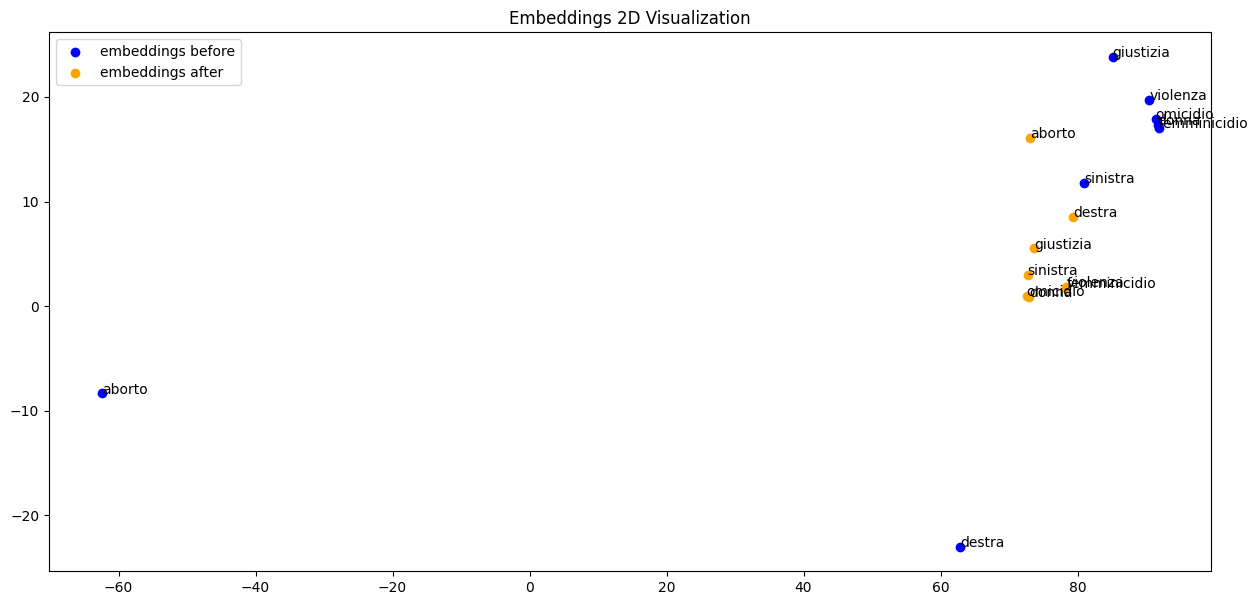

In [ ]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_before['x'], df_before['y'], color = 'blue', label = 'embeddings before')
ax.scatter(df_after['x'], df_after['y'], color = 'orange', label = 'embeddings after')
ax.legend()

for word, pos in df_before.iterrows():
    ax.annotate(word, pos)
for word, pos in df_after.iterrows():
    ax.annotate(word, pos)
plt.title('Embeddings 2D Visualization')
plt.show()

## Word Comparison

In [56]:
from copy import deepcopy

#define a function that converts the word2vec models into numpy arrays
def w2v_to_numpy (model):
  model.wv.fill_norms()
  embeddings = deepcopy (model.wv.get_normed_vectors())
  idx = {w:i for i, w in enumerate (model.wv.index_to_key)}
  iidx = {i:w for i, w in enumerate (model.wv.index_to_key)}

  return embeddings, (idx, iidx)

#define a function that returns the nearest neighbors of a query
def near_neighbors (embs, query, word2rownum, rownum2word, k=30):
  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)

  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

In [57]:
#define functions to make meaningful comparisons of words across models
def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  omega = procrustes (remapped_mat1, remapped_mat2)

  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [58]:
before_embs, (before_idx, before_iidx) = w2v_to_numpy(w2v_before)
after_embs, (after_idx, after_iidx) = w2v_to_numpy(w2v_after)
before_aligned_embs, after_aligned_embs, (common_idx, common_iidx) = align_matrices (before_embs, after_embs, before_idx, after_idx)

In [95]:
#define the sets of words
victim_words = ['vittima', 'assassinata','innocente']
murderer_words = ['omicida', 'assassino', 'mostro', 'colpevole','delinquente', 'criminale']
emotional_neg_words = ['gelosia', 'tradimento', 'rifiuto','vendetta', 'rabbia']
emotional_pos_words = ['passione','felici', 'amore', 'rispetto']
crude_words = ['sangue', 'cadavere', 'strangolata', 'violenza', 'tortura']
modal_words = ['dovere', 'necessario', 'bisogno', 'occorre', 'urgente', 'essenziale', 'fondamentale']
patriarchy_words = ['uomo', 'patriarcato', 'ingiustizia', 'oppressione', 'discriminazione','sessismo', 'retrogrado']
blame_shifting_words = ['vestita', 'irresponsabile', 'ingenua']


## Across models comparison (how words evolved over time)

In [63]:
#victim related words comparison across models
victim_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in victim_words]
for w,score in sorted (victim_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

assassinata 0.9930908
innocente 0.991181
vittima 0.92675287


In [64]:
#murderer related words comparison across models
murderer_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in murderer_words]
for w,score in sorted (murderer_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

mostro 0.9858699
omicida 0.9851789
assassino 0.9824849
colpevole 0.9820498
criminale 0.97628826
delinquente 0.94580215


In [65]:
#negative emotional words comparison across models
emotional_neg_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_neg_words]
for w,score in sorted (emotional_neg_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

rifiuto 0.9953313
vendetta 0.98626626
gelosia 0.97198963
tradimento 0.9580295


In [66]:
#positive emotional words comparison across models
emotional_pos_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_pos_words]
for w,score in sorted (emotional_pos_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

felici 0.9890923
passione 0.9725436
rispetto 0.9654434
amore 0.9621887


In [67]:
#crude words comparison across models
crude_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in crude_words]
for w,score in sorted (crude_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sangue 0.9953735
cadavere 0.98915166
strangolata 0.9423558
violenza 0.8784188
tortura 0.8332832


In [68]:
#modal words comparison across models
modal_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in modal_words]
for w,score in sorted (modal_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

occorre 0.99728763
fondamentale 0.9956554
dovere 0.99505234
urgente 0.99257237
bisogno 0.9890412
necessario 0.98876804
essenziale 0.96374184


In [69]:
#patriarchy words comparison across models
patriarchy_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in patriarchy_words]
for w,score in sorted (patriarchy_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

oppressione 0.9846478
discriminazione 0.96962357
sessismo 0.96760476
ingiustizia 0.9666253
uomo 0.9378811
patriarcato 0.937413
retrogrado 0.8685795


In [96]:
#blamshifting words comparison across models
blame_shifting_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in blame_shifting_words]
for w,score in sorted (blame_shifting_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

vestita 0.97383034
irresponsabile 0.9288289
ingenua 0.86110604


We now compare the most and least similar words between the models, across the entire vocabulary

In [71]:
sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in common_idx.keys()]

print('Most similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:10]:
  print (w, sim)
print()
print()
print('Least similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:10]:
  print (w, sim)

Most similar words
condanna 0.9986571
euro 0.99863446
maniera 0.998469
lettura 0.9984152
pensa 0.99828374
chiesa 0.9982685
programma 0.99823856
pare 0.9982166
coloro 0.9981061
centri 0.9980825


Least similar words
assegnazione -0.516394
troverei -0.49362203
marieclaireitattualitanew -0.43857938
schiaffetto -0.42374662
trentanove -0.40554112
consolare -0.38942343
faida -0.38666594
porterebbero -0.33817136
sostenevo -0.32516092
casalinga -0.32026786


## Within model comparison

In [73]:
#nearest neighbors for victim related words
for word in victim_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "vittima" in the before corpus
('denunciato', 0.98460376)
('ammazzata', 0.9836399)
('ieri', 0.9835448)
('mandatoriccio', 0.9826974)
('orribilmente', 0.9817418)
('rimini', 0.98163944)
('unaltra', 0.9797741)
('bologna', 0.9797378)
('investita', 0.9795173)
('bellariva', 0.97919565)
('marsala', 0.97873056)
('incinta', 0.9781473)
('andreea', 0.97798294)
('roma', 0.97794724)
('lentini', 0.97567713)
('altra', 0.9754318)
('rapina', 0.9753462)
('dopo', 0.97520083)
('pierpaola', 0.9748391)
('ultim', 0.9746626)
('giovane', 0.974275)
('giulia', 0.97341883)
('calabria', 0.9733726)
('raggiunta', 0.97309905)
('ragazza', 0.97309864)
('assassinata', 0.97285247)
('brutalmente', 0.97229385)
('picchiata', 0.9720513)
('vigilia', 0.9718895)
('alexander', 0.9717552)

Near neighbors for "vittima" in the after corpus
('ennesima', 0.9673362)
('vinta', 0.95752156)
('allennesima', 0.95163214)
('lennesima', 0.9488954)
('conferito', 0.9486114)
('firmata', 0.94484043)
('tolta', 0.9428085)
('altra'

In [75]:
#nearest neighbors for murderer related words
for word in murderer_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "omicida" in the before corpus
('polizia', 0.9993453)
('chiesto', 0.99923134)
('giuseppe', 0.9992171)
('fermo', 0.9988545)
('auto', 0.9987922)
('risponde', 0.9986478)
('antonio', 0.998481)
('procura', 0.99840635)
('fuggire', 0.9984038)
('ucciderla', 0.9984)
('amico', 0.9983045)
('vicini', 0.9982831)
('origini', 0.9982646)
('confesso', 0.9981711)
('ragazzo', 0.99816126)
('telefonata', 0.9980862)
('lomicida', 0.9979883)
('indagini', 0.9979046)
('urla', 0.99779534)
('lanciato', 0.9977732)
('processo', 0.9977686)
('molaro', 0.9976934)
('gabriela', 0.9976808)
('milano', 0.99767387)
('lho', 0.9976046)
('bastardo', 0.99758905)
('zona', 0.99756205)
('sentenza', 0.9975341)
('parliamodinewsarticleahr', 0.997522)
('accusa', 0.9975151)

Near neighbors for "omicida" in the after corpus
('fratello', 0.9988748)
('saputo', 0.9977959)
('essersi', 0.99776417)
('verra', 0.9977178)
('raccontato', 0.99766594)
('gia', 0.99760985)
('condanna', 0.9975712)
('scoperto', 0.9974824)
('premio', 

In [80]:
#nearest neighbors for positive emotional words
for word in emotional_pos_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "passione" in the before corpus
('verra', 0.99852103)
('neppure', 0.9980446)
('luogo', 0.9979205)
('capelli', 0.99791753)
('armi', 0.99788934)
('this', 0.99788123)
('laura', 0.99780196)
('momento', 0.9977948)
('breve', 0.99773437)
('macchia', 0.99773026)
('servizio', 0.9977277)
('film', 0.9977125)
('incontri', 0.99766445)
('vuoto', 0.99761504)
('andava', 0.99760634)
('tragica', 0.99760437)
('scrive', 0.997579)
('depressione', 0.9975225)
('reazione', 0.9975205)
('psichiatra', 0.9975126)
('fala', 0.9975043)
('addosso', 0.9975036)
('inaccettabile', 0.99749696)
('vicenda', 0.99747634)
('deciso', 0.9974358)
('putin', 0.9974176)
('sobre', 0.997408)
('assassinio', 0.9974004)
('accanto', 0.9973759)
('gesto', 0.99736965)

Near neighbors for "passione" in the after corpus
('immigrato', 0.994276)
('uxoricidio', 0.9934849)
('bianco', 0.993455)
('legittima', 0.9922911)
('extracomunitario', 0.99174523)
('decide', 0.99018717)
('bestia', 0.9901466)
('nato', 0.9899866)
('colpevole', 

In [76]:
#nearest neighbors for negative emotional words
for word in emotional_neg_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "gelosia" in the before corpus
('delirio', 0.9987161)
('pazzo', 0.9980975)
('coppia', 0.9977912)
('violento', 0.9973022)
('nero', 0.9969885)
('bianco', 0.9967023)
('chiamare', 0.99667764)
('maltrattamenti', 0.9961144)
('lomicidio', 0.9960772)
('lasciare', 0.99585927)
('difende', 0.99553776)
('origine', 0.99553084)
('definito', 0.9953729)
('chiamato', 0.99537015)
('salvatore', 0.9952676)
('uccido', 0.99523795)
('lascia', 0.99484384)
('libero', 0.994818)
('denaro', 0.9947655)
('mafioso', 0.99472904)
('quell', 0.9946896)
('lergastolo', 0.9946787)
('furia', 0.99464726)
('potenziale', 0.9946032)
('crudelta', 0.99457157)
('onore', 0.9944655)
('propria', 0.994431)
('diceva', 0.9943508)
('veneto', 0.9943392)
('preso', 0.99425876)

Near neighbors for "gelosia" in the after corpus
('sconosciuto', 0.99343777)
('accetta', 0.99083865)
('proprieta', 0.99018586)
('oggetto', 0.9897113)
('ritiene', 0.9895518)
('omosessuale', 0.9893654)
('invidia', 0.9891781)
('ama', 0.9890025)
('iden

In [77]:
#nearest neighbors for crude words
for word in crude_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "sangue" in the before corpus
('minacce', 0.9986254)
('portato', 0.998502)
('corso', 0.99843633)
('terra', 0.99820375)
('furia', 0.9980366)
('svolta', 0.9979354)
('palermo', 0.9979343)
('venerdi', 0.9979056)
('sindaco', 0.9978964)
('giallo', 0.9978937)
('figlie', 0.99788964)
('torino', 0.9978373)
('racconto', 0.99782985)
('condanna', 0.9977528)
('ricevuto', 0.9977206)
('domenica', 0.9977045)
('roberta', 0.99758583)
('sacco', 0.997577)
('romani', 0.9975191)
('centro', 0.9975115)
('premio', 0.99742913)
('news', 0.99742055)
('cristina', 0.99736845)
('appello', 0.99735415)
('gabriele', 0.9972806)
('napoli', 0.99725574)
('attesa', 0.99723184)
('attorno', 0.99722815)
('allarme', 0.9972174)
('pugno', 0.99718213)

Near neighbors for "sangue" in the after corpus
('maria', 0.99864256)
('giovedi', 0.9981719)
('cuore', 0.997162)
('padova', 0.99702823)
('mattina', 0.9968408)
('milano', 0.9967464)
('mandato', 0.99630105)
('carabiniere', 0.99626315)
('ilfattoquotidianoit', 0.995897

In [78]:
#nearest neighbors for modal words
for word in modal_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "dovere" in the before corpus
('bravi', 0.99815583)
('tempo', 0.99799633)
('giro', 0.9979929)
('spero', 0.99789596)
('saro', 0.99780387)
('femminista', 0.99780107)
('sentite', 0.9977869)
('eventi', 0.9977863)
('soliti', 0.9977809)
('venire', 0.99775463)
('quei', 0.9977296)
('permette', 0.99770594)
('riusciamo', 0.9975834)
('vedo', 0.99753356)
('buona', 0.9974936)
('finalmente', 0.9974746)
('bassi', 0.99745953)
('opera', 0.99744934)
('riesco', 0.9974223)
('conto', 0.99740577)
('culo', 0.9973767)
('manco', 0.9973617)
('ipocrisia', 0.99732506)
('periodo', 0.9972986)
('stampa', 0.9972942)
('nazione', 0.9972737)
('magari', 0.99725306)
('atrocita', 0.9972347)
('addirittura', 0.9972197)
('talmente', 0.99721813)

Near neighbors for "dovere" in the after corpus
('tenere', 0.9985244)
('terrorismo', 0.99792916)
('gusto', 0.9977897)
('chiedere', 0.9976926)
('cura', 0.9976746)
('interviste', 0.99761695)
('salvare', 0.9974747)
('pensieri', 0.9974703)
('rimanere', 0.9974679)
('calc

In [79]:
#nearest neighbors for patriarchy words
for word in patriarchy_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "uomo" in the before corpus
('uccidi', 0.96367973)
('ammazza', 0.9582733)
('rapinatore', 0.95730186)
('donna', 0.9543807)
('rapina', 0.9529615)
('banca', 0.9488383)
('uccide', 0.9477811)
('massacra', 0.9420193)
('assolto', 0.9395514)
('ravenna', 0.9371419)
('accetta', 0.9370929)
('cuscino', 0.9336059)
('indignatevi', 0.9329933)
('picchia', 0.9324995)
('padova', 0.93230903)
('cagliaritano', 0.93179804)
('litiga', 0.9313078)
('incinta', 0.9305232)
('accoltellato', 0.9300941)
('muore', 0.929887)
('stuprato', 0.92944276)
('ex', 0.92933273)
('cagliari', 0.9291656)
('vita', 0.9280485)
('picchiava', 0.927789)
('impicca', 0.92773455)
('amante', 0.9276469)
('corrieredelvenetocorrierei', 0.92755187)
('luomo', 0.9264017)
('giurata', 0.92630637)

Near neighbors for "uomo" in the after corpus
('donna', 0.9780089)
('uccide', 0.9738524)
('viene', 0.97140795)
('uccidere', 0.96818316)
('uccido', 0.9678377)
('muore', 0.9675658)
('uccisione', 0.96192497)
('indica', 0.9603395)
('scompar

In [97]:
#nearest neighbors for blame shifting words
for word in blame_shifting_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=30):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=30):
    print (item)
  print()
  print()

Near neighbors for "vestita" in the before corpus
('incontri', 0.9955752)
('armi', 0.9955638)
('futuro', 0.99535835)
('putin', 0.99534154)
('assoluzione', 0.9953395)
('verra', 0.9953307)
('psichiatra', 0.99531996)
('inaccettabile', 0.9952945)
('passione', 0.9952872)
('laura', 0.995252)
('soldi', 0.9952251)
('luogo', 0.9952115)
('this', 0.9952048)
('mulheres', 0.9952039)
('film', 0.995185)
('neppure', 0.99518013)
('contra', 0.9951527)
('vicenda', 0.9951304)
('messo', 0.99512947)
('momento', 0.9951266)
('cera', 0.99511564)
('scrive', 0.9951)
('depressione', 0.9950943)
('chiave', 0.99508405)
('tragica', 0.99507475)
('gesto', 0.9950743)
('domande', 0.9950707)
('seminario', 0.99501765)
('partito', 0.99501294)
('macchia', 0.99498975)

Near neighbors for "vestita" in the after corpus
('veste', 0.99272954)
('felpa', 0.9926368)
('spero', 0.991905)
('deciso', 0.99183357)
('riesco', 0.9914702)
('scritta', 0.9912745)
('reagire', 0.99120444)
('unica', 0.99089)
('atroce', 0.9908691)
('giustizia', 0.